In [67]:
import rasterio
from rasterio.mask import mask
import os, sys
import numpy as np
import sklearn
from sklearn.cluster import MiniBatchKMeans, KMeans
import fiona
from matplotlib import pyplot as plt
from scipy.misc import bytescale
from mpl_toolkits.axes_grid1 import make_axes_locatable

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)

## write my own majority filter..
def majority_agg(arr, factor):
    
    # get the ranges of pixels to grab from planet
    row_sets = np.arange(0, arr.shape[0], factor)
    col_sets = np.arange(0, arr.shape[1], factor)
    
    # allocate new array
    new_arr = np.zeros((row_sets.size, col_sets.size))
    for i,r in enumerate(row_sets[:-2]):
        for j,c in enumerate(col_sets[:-2]):
            
            # get the start/stop for the slice
            row_start = int(row_sets[i])
            row_end = int(row_sets[i+1])
            col_start = int(col_sets[j])
            col_end = int(col_sets[j+1])
                        
            #get the pixels
            pixels = arr[row_start:row_end, col_start:col_end]
            
            # get the value (majority)
            val = np.argmax(np.bincount(pixels.ravel()))
            
            new_arr[i,j] = val
    
    return new_arr

# function to plot rgb image with mask
def plot_rgb(arr):
    
    if arr.shape[-1] != 3:
        raise Exception('Input needs to be 3 band, and band channel needs to be last channel')
        
    if type(arr) is np.ma.MaskedArray:
        # build alpha channel        
        mask = np.ma.getmask(arr[:,:,0])
        mask = ~mask * 255
        
        # add the mask to the array (ise earthpy bytescale)
        plot_arr = np.dstack((bytescale(arr),mask))
        
        # plot it
        plt.imshow(plot_arr)
        plt.show()
        
    else: #no mask, no worries
        plt.imshow(plot_arr)
        
    return plot_arr

In [68]:
# specify some shape files
sjer_aoi_shp = '../shp/planet_sub_mosaic_intersect_SJER_AOI.shp'
sjer_bound_shp = '../shp/Export_Output.shp'

# specify some image files for March 12
planet_mar12 = '../march_2017_planet_scenes/20170312_180045_0e3a/20170312_180045_0e3a_3B_AnalyticMS_SR.tif'
l8_mar12_base = '../landsat8/SR/LC080420342017031201T1-SC20180503152939/LC08_L1TP_042034_20170312_20170317_01_T1_sr_'
l8_mar12_bands = [l8_mar12_base + b + '.tif' for b in ['band2', 'band3', 'band4', 'band5']]
l8_mar12_bands



['../landsat8/SR/LC080420342017031201T1-SC20180503152939/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band2.tif',
 '../landsat8/SR/LC080420342017031201T1-SC20180503152939/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band3.tif',
 '../landsat8/SR/LC080420342017031201T1-SC20180503152939/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band4.tif',
 '../landsat8/SR/LC080420342017031201T1-SC20180503152939/LC08_L1TP_042034_20170312_20170317_01_T1_sr_band5.tif']

In [69]:
## load images as numpy arrays
# load aoi
with fiona.open(sjer_aoi_shp, "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

# first planet
with rasterio.open(planet_mar12, 'r') as src:
    pl_arr = mask(src, geoms, crop=True, nodata=0, all_touched=True)[0]
    
# move bands to back
pl_arr = np.rollaxis(pl_arr, 0,3)
    
# then landsat
l_ls = []
for lb in l8_mar12_bands:
    with rasterio.open(lb, 'r') as src:
        temp_arr = mask(src, geoms, crop=True, nodata=0, all_touched=True)[0].squeeze()
    
    l_ls.append(temp_arr)

# make list to array and roll bands to back
l8_arr = np.ma.array(l_ls)
l8_arr = np.rollaxis(l8_arr, 0,3)

## explicitly set the mask
l8_arr = np.ma.masked_equal(l8_arr, 0).astype('float32')/10000.
pl_arr = np.ma.masked_equal(pl_arr, 0).astype('float32')/10000.

pl_rgb = pl_arr[:,:,[2,1,0]]
l8_rgb = l8_arr[:,:,[2,1,0]]



### train a K means classifier on PlanetScope 4-band SR data, and apply to Landsat 8 (4 bands)

## Look at inertia plots for planet and landsat k means classifiers

In [70]:
# Data is contained in 

# specify a range of cluster values
range_n_clusters = range(3,10)

# make the X array
X = l8_arr.reshape(-1,4)
mask = np.ma.getmask(X)
mask_inds = np.where(~mask.all(axis=1))[0]
Xt = X[mask_inds,:]
Xt.shape, X.shape


((41259, 4), (58464, 4))

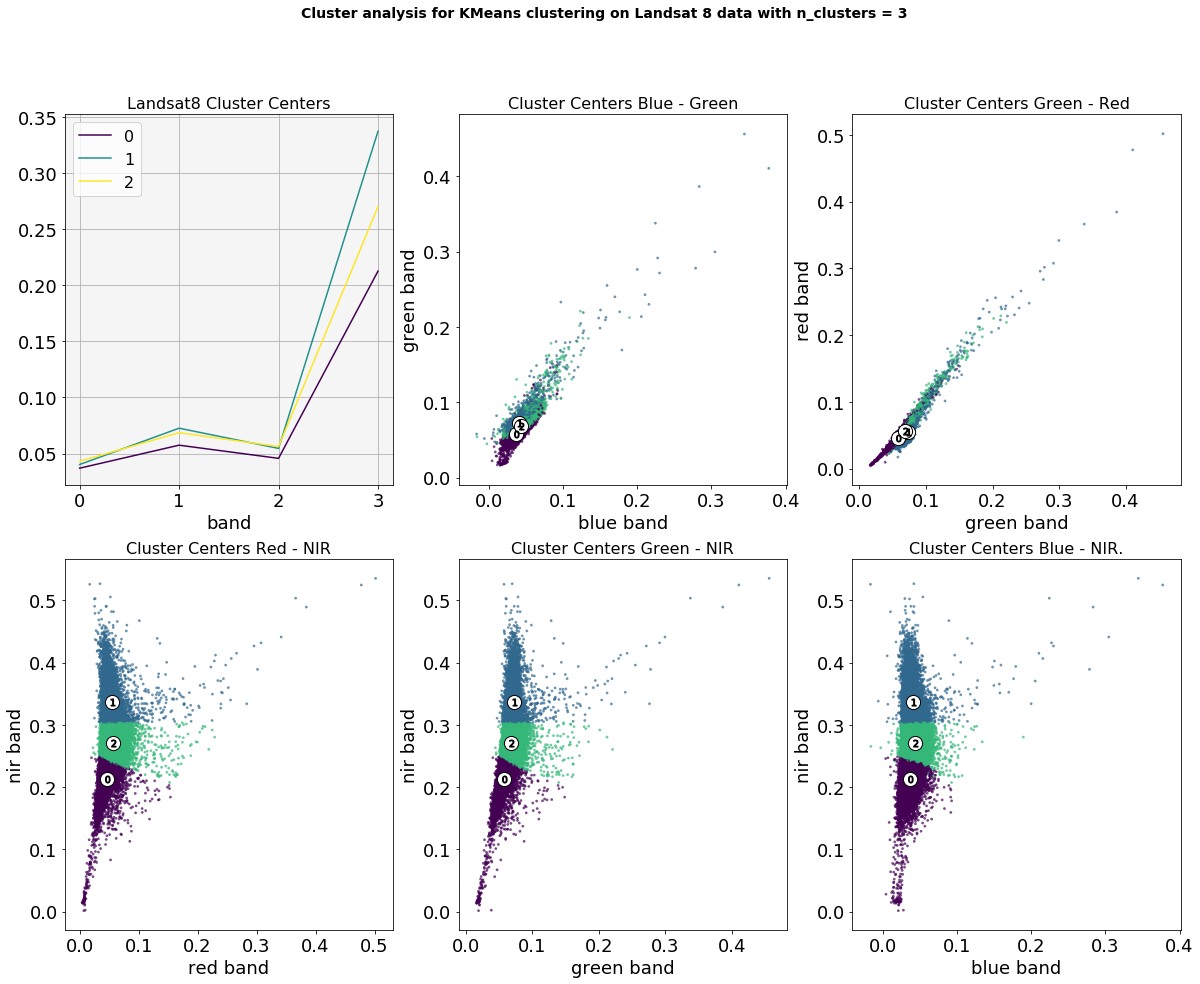

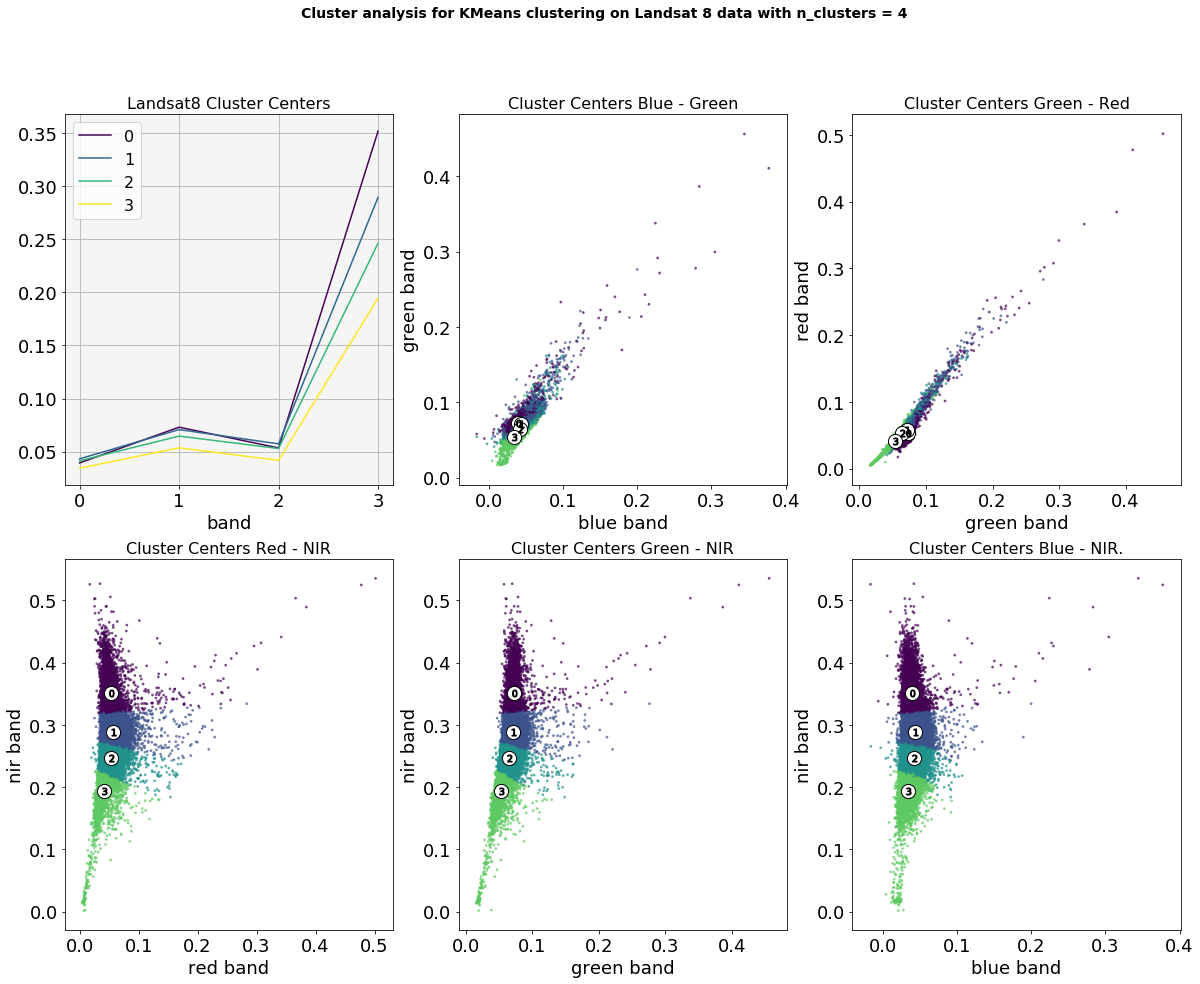

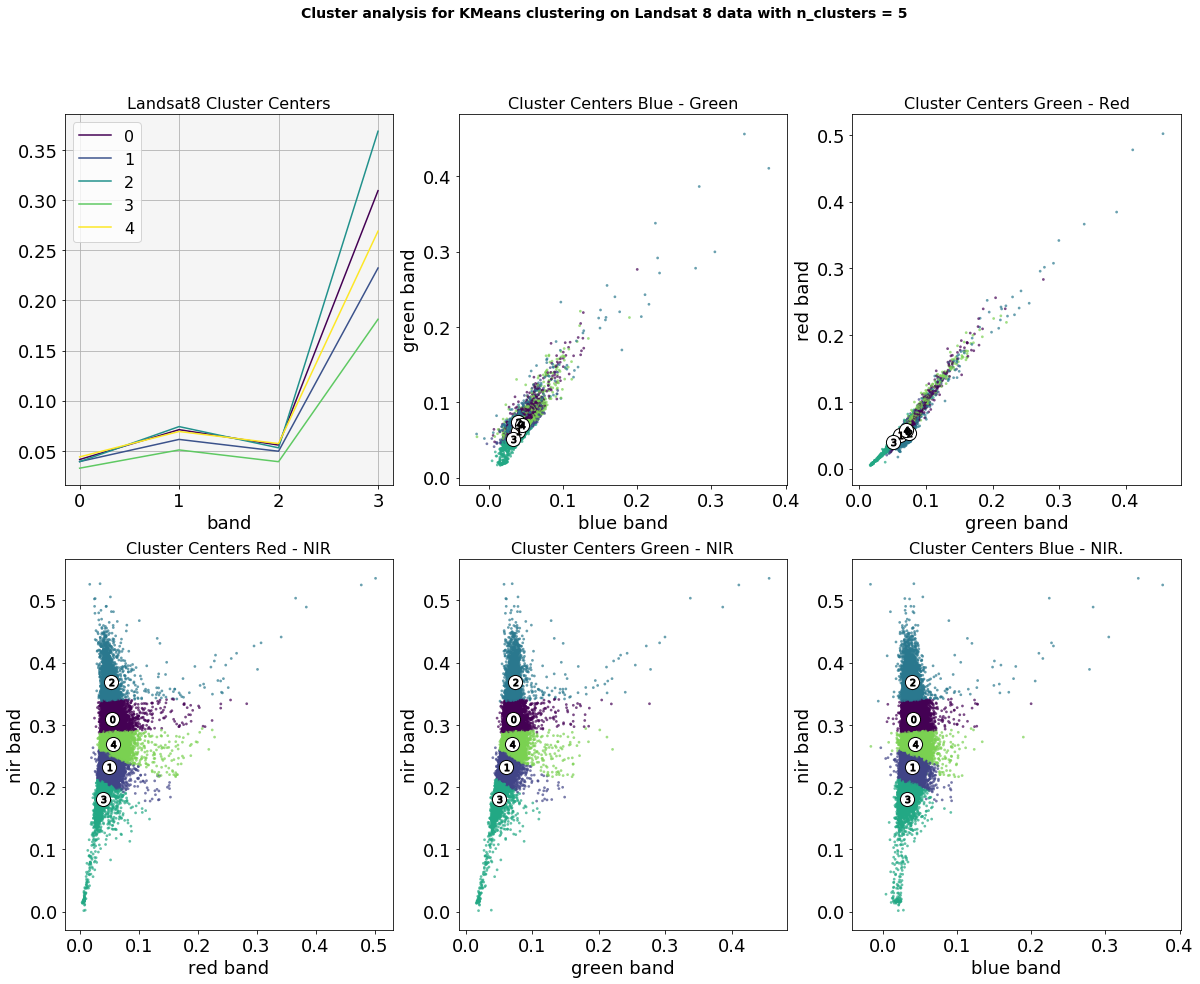

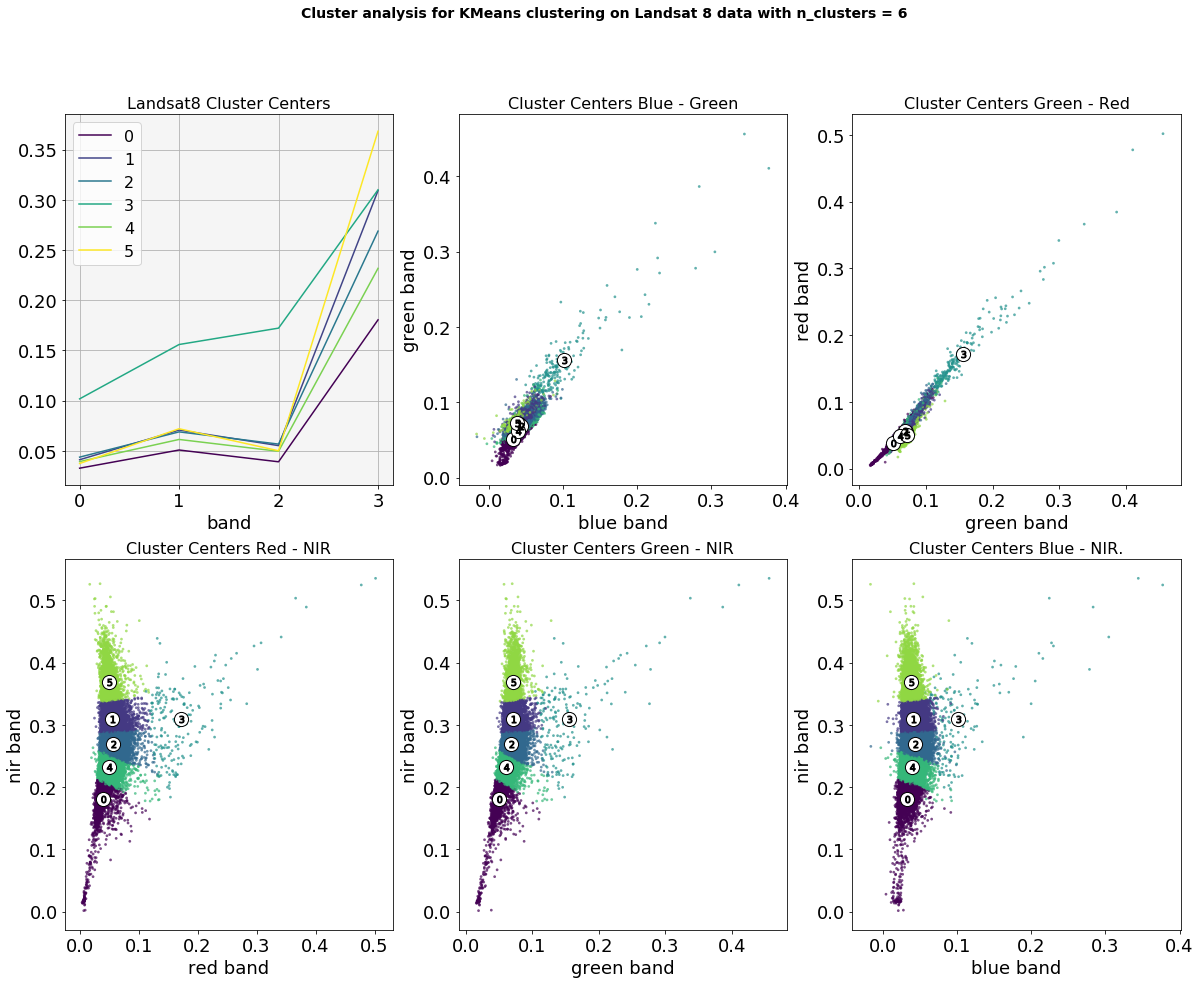

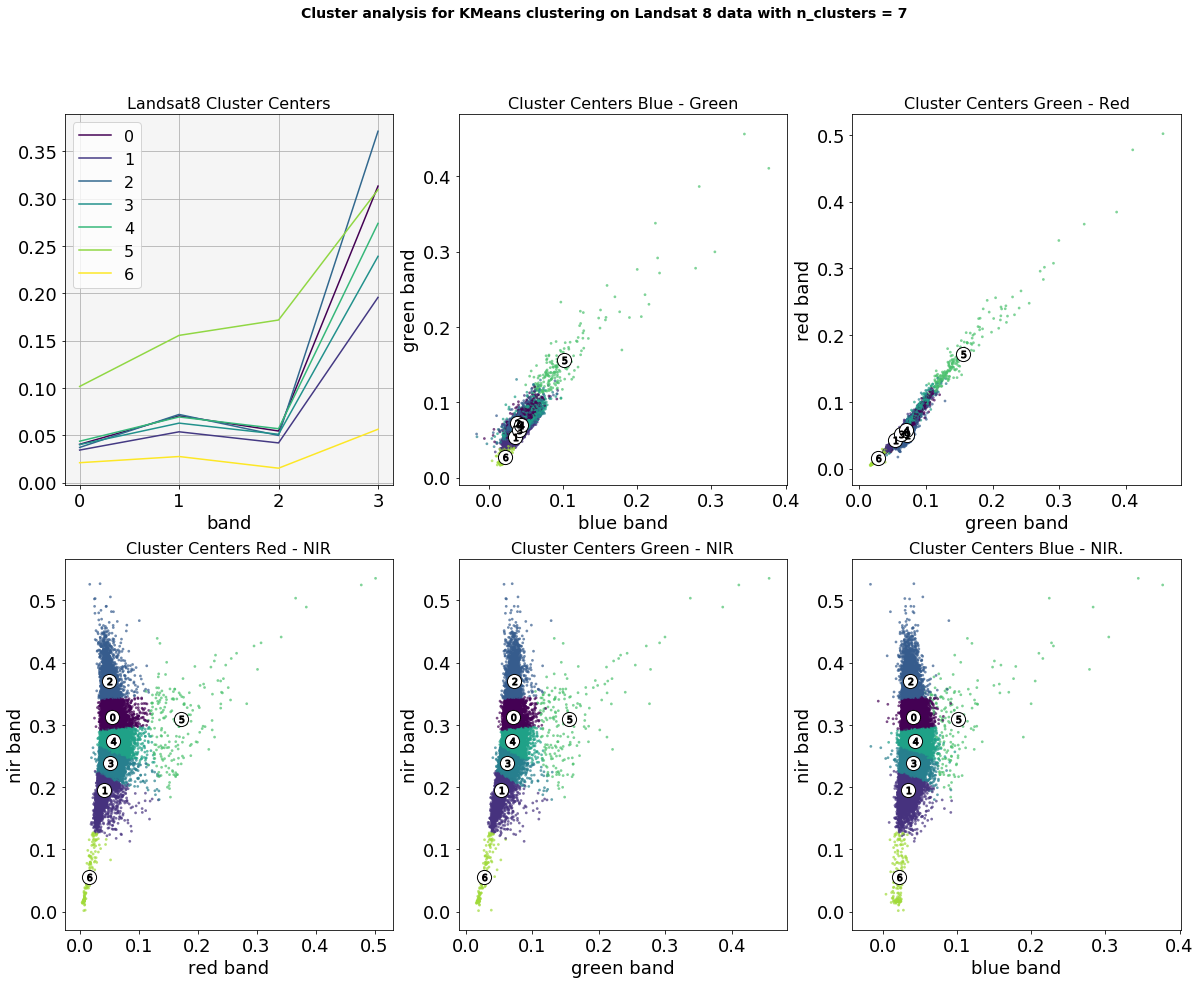

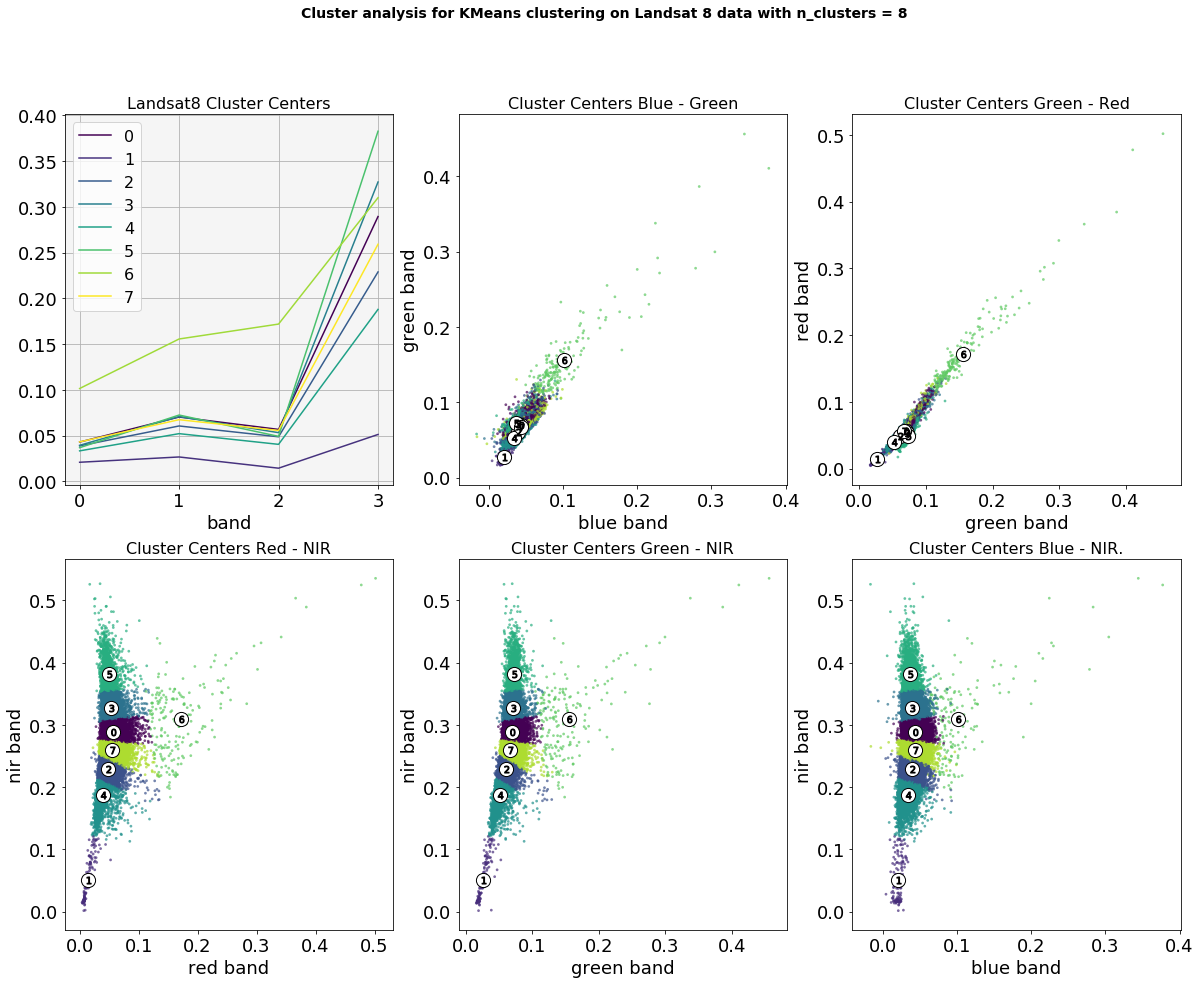

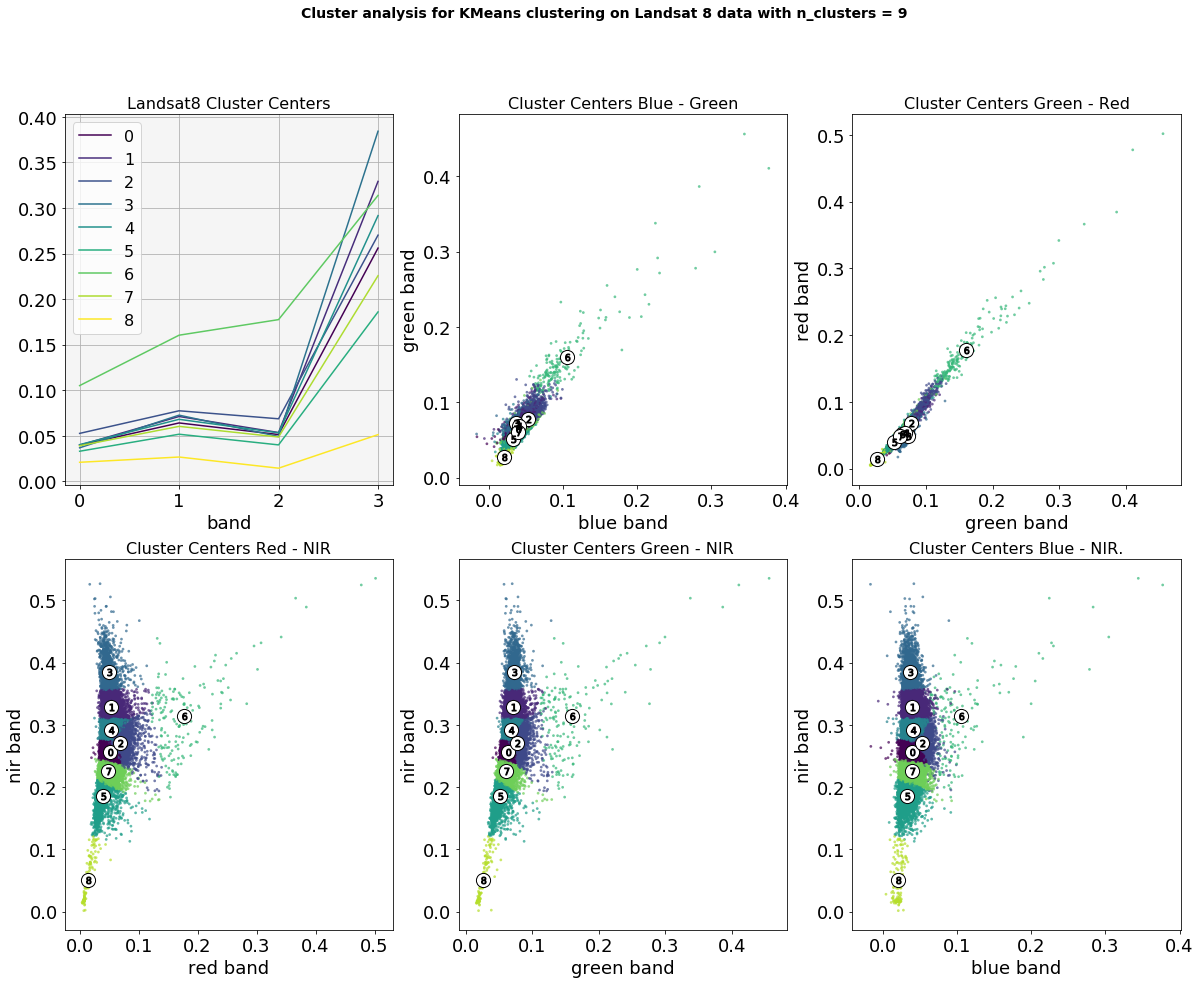

In [71]:
l8_inertia = []
l8_kmeans = []

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Xt)

    # store infor
    l8_kmeans.append(clusterer)
    l8_inertia.append(clusterer.inertia_ / Xt.shape[0])

    y_lower = 10
    
    # plot the clusters
    colors=iter(plt.cm.viridis(np.linspace(0,1,n_clusters)))

    # set up the figure
    fig, axes = plt.subplots(2,3)
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[0,2]
    ax4 = axes[1,0]
    ax5 = axes[1,1]
    ax6 = axes[1,2]
    
    fig.set_size_inches(20, 15)
    
    centers = clusterer.cluster_centers_
    labels= [str(i) for i in range(centers.shape[0])]
    for i,c in enumerate(colors):
        ax1.plot(centers[i,:], color=c, label=labels[i])

    ax1.legend()
    ax1.set_title('Landsat8 Cluster Centers')
    ax1.set_xlabel('band')
    ax1.set_facecolor('whitesmoke')
    ax1.grid()

    
    # 2nd Plot showing the actual clusters formed for blue vs. green
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Cluster Centers Blue - Green")
    ax2.set_xlabel("blue band")
    ax2.set_ylabel("green band")
    
    
    # 3rd Plot showing the actual clusters formed for green vs. red
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax3.scatter(X[:, 1], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax3.scatter(centers[:, 1], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax3.scatter(c[1], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax3.set_title("Cluster Centers Green - Red")
    ax3.set_xlabel("green band")
    ax3.set_ylabel("red band")
    
    # 4th Plot showing the actual clusters formed for red vs. nir
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax4.scatter(X[:, 2], X[:, -1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax4.scatter(centers[:, 2], centers[:, -1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax4.scatter(c[2], c[-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax4.set_title("Cluster Centers Red - NIR")
    ax4.set_xlabel("red band")
    ax4.set_ylabel("nir band")
    
    # 5th Plot showing the actual clusters formed for green vs. nir
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax5.scatter(X[:, 1], X[:, -1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax5.scatter(centers[:, 1], centers[:, -1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax5.scatter(c[1], c[-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax5.set_title("Cluster Centers Green - NIR")
    ax5.set_xlabel("green band")
    ax5.set_ylabel("nir band")
    
    # 5th Plot showing the actual clusters formed for blue vs. nir
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax6.scatter(X[:, 0], X[:, -1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax6.scatter(centers[:, 0], centers[:, -1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax6.scatter(c[0], c[-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax6.set_title("Cluster Centers Blue - NIR.")
    ax6.set_xlabel("blue band")
    ax6.set_ylabel("nir band")
    
    

    plt.suptitle(("Cluster analysis for KMeans clustering on Landsat 8 data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    figname = 'KMeans_Landsat8_clusters_{}.png'.format(n_clusters)
    fig_path = r'C:\Projects\RD\planet\SPIE_research\figs\kmeans_inertia'
    fig_file = os.path.join(fig_path, figname)
    fig.savefig(fig_file)
    plt.show()
    


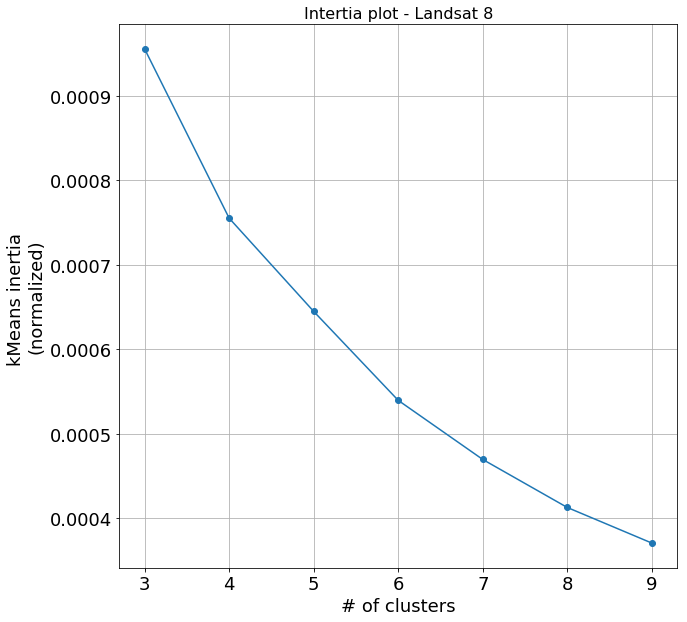

In [72]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(range_n_clusters, l8_inertia, 'o-')
ax.set_xlabel('# of clusters')
ax.set_ylabel('kMeans inertia \n(normalized)')
ax.set_title('Intertia plot - Landsat 8')
ax.set_xticks(range_n_clusters, minor=True)
ax.grid()

figname = 'KMeans_Landsat8_clusters_inertia_plot.png'.format(n_clusters)
fig_path = r'C:\Projects\RD\planet\SPIE_research\figs\kmeans_inertia'
fig_file = os.path.join(fig_path, figname)
fig.savefig(fig_file)
plt.show()


## do the same for Planet scene

In [88]:
# Data is contained in 

# specify a range of cluster values
range_n_clusters = range(3,10)

# make the X array
X = pl_arr.reshape(-1,4)
mask = np.ma.getmask(X)
mask_inds = np.where(~mask.all(axis=1))[0]
Xt = X[mask_inds,:]
Xt.shape, X.shape


((4071062, 4), (5797230, 4))

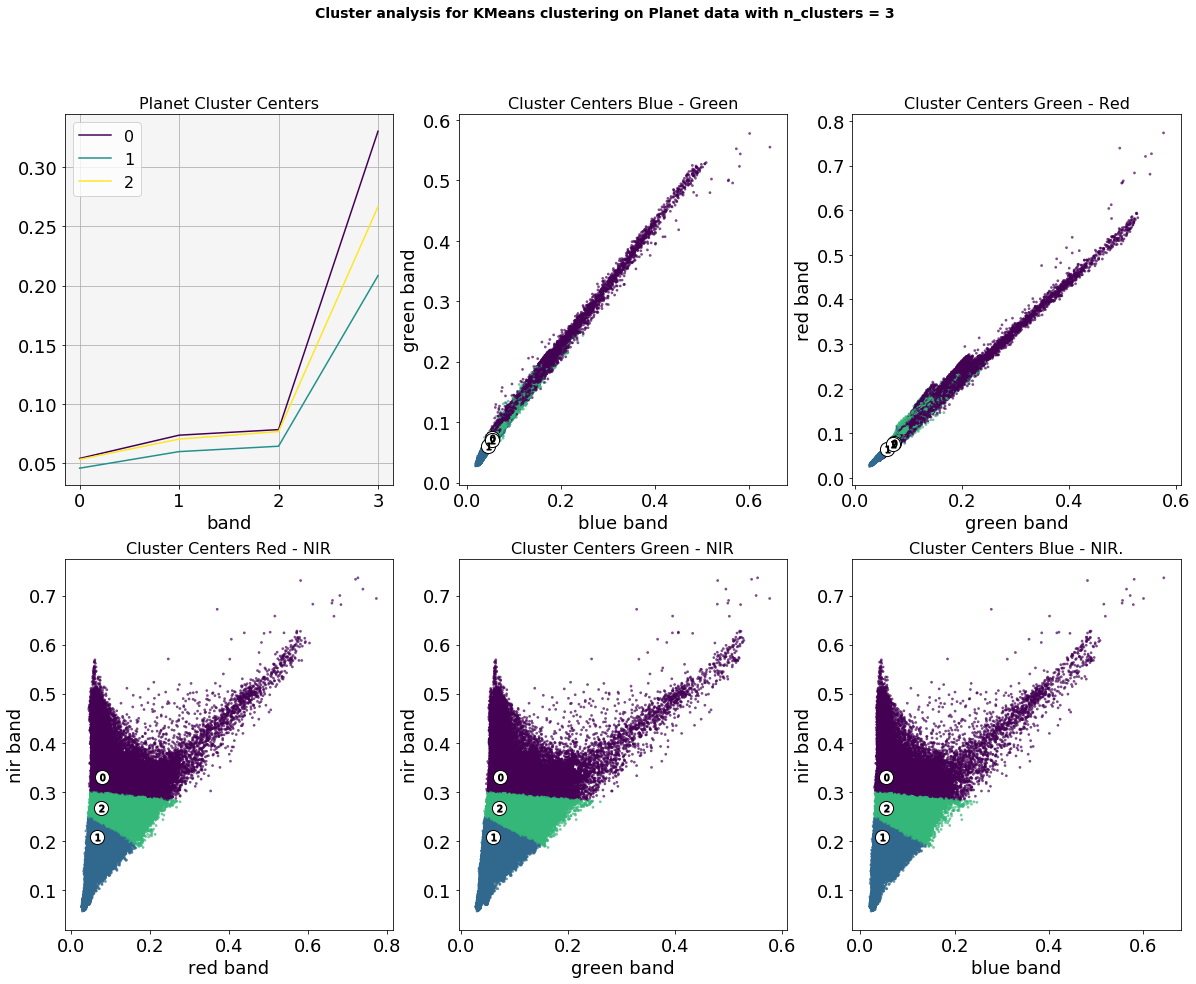

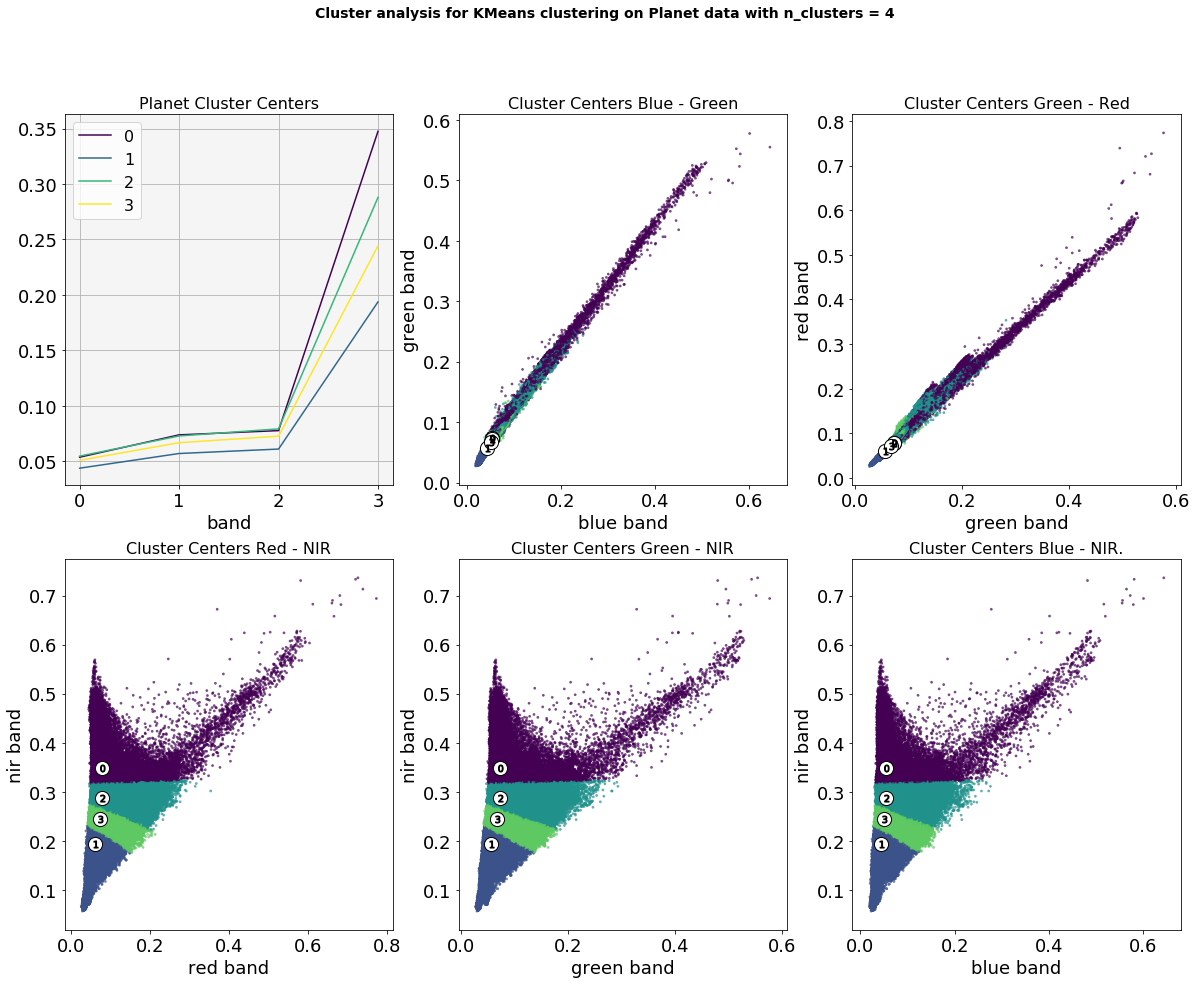

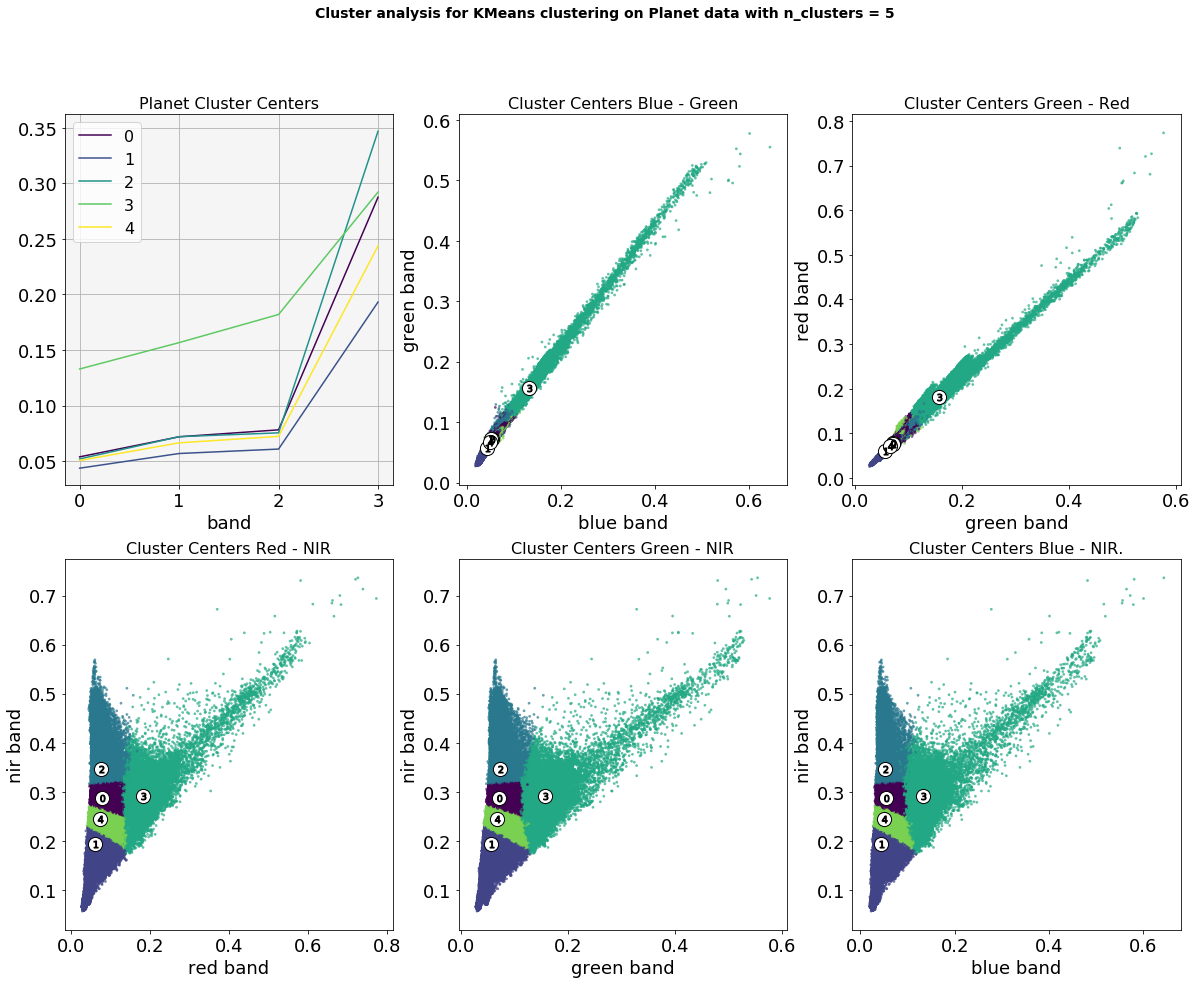

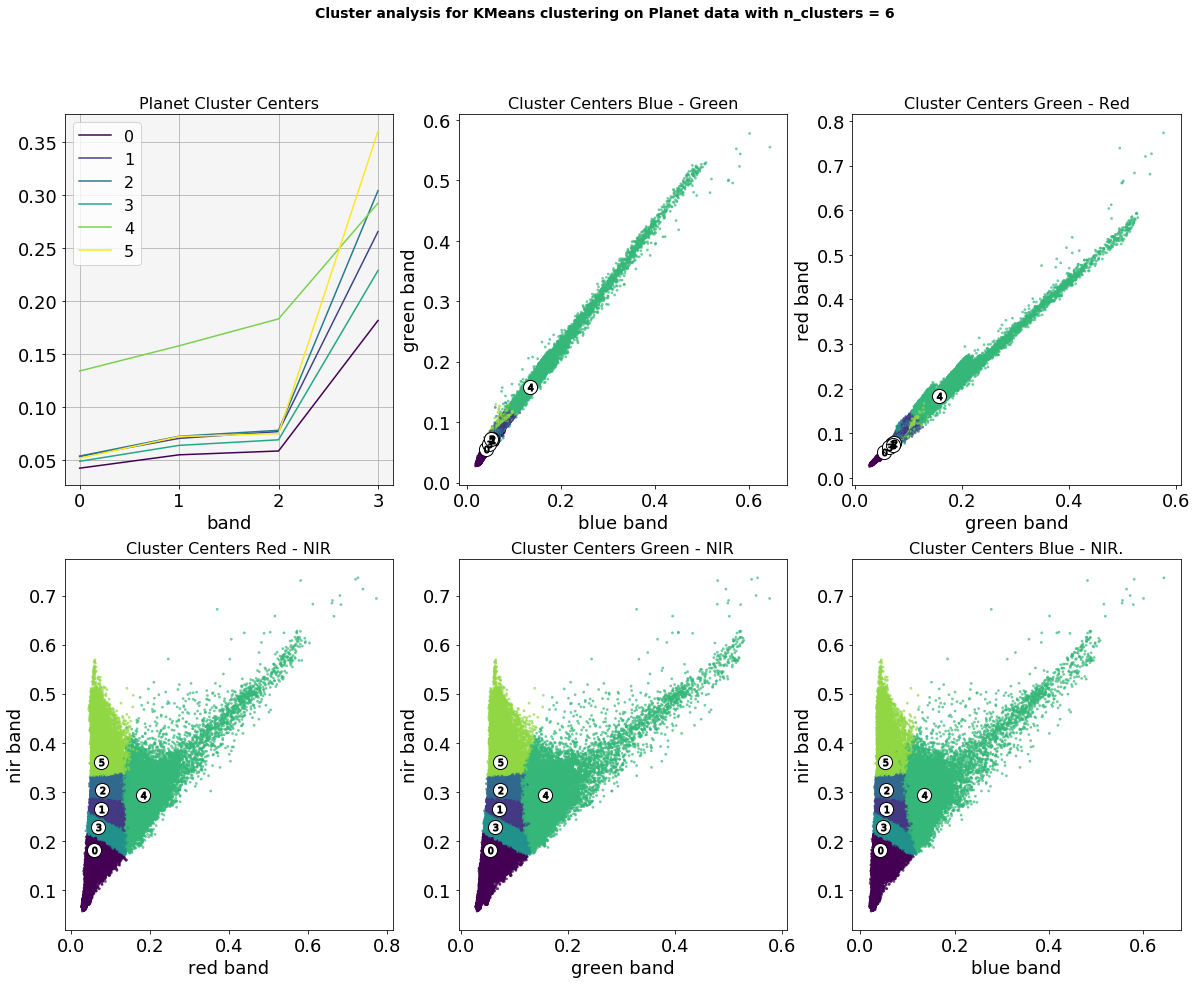

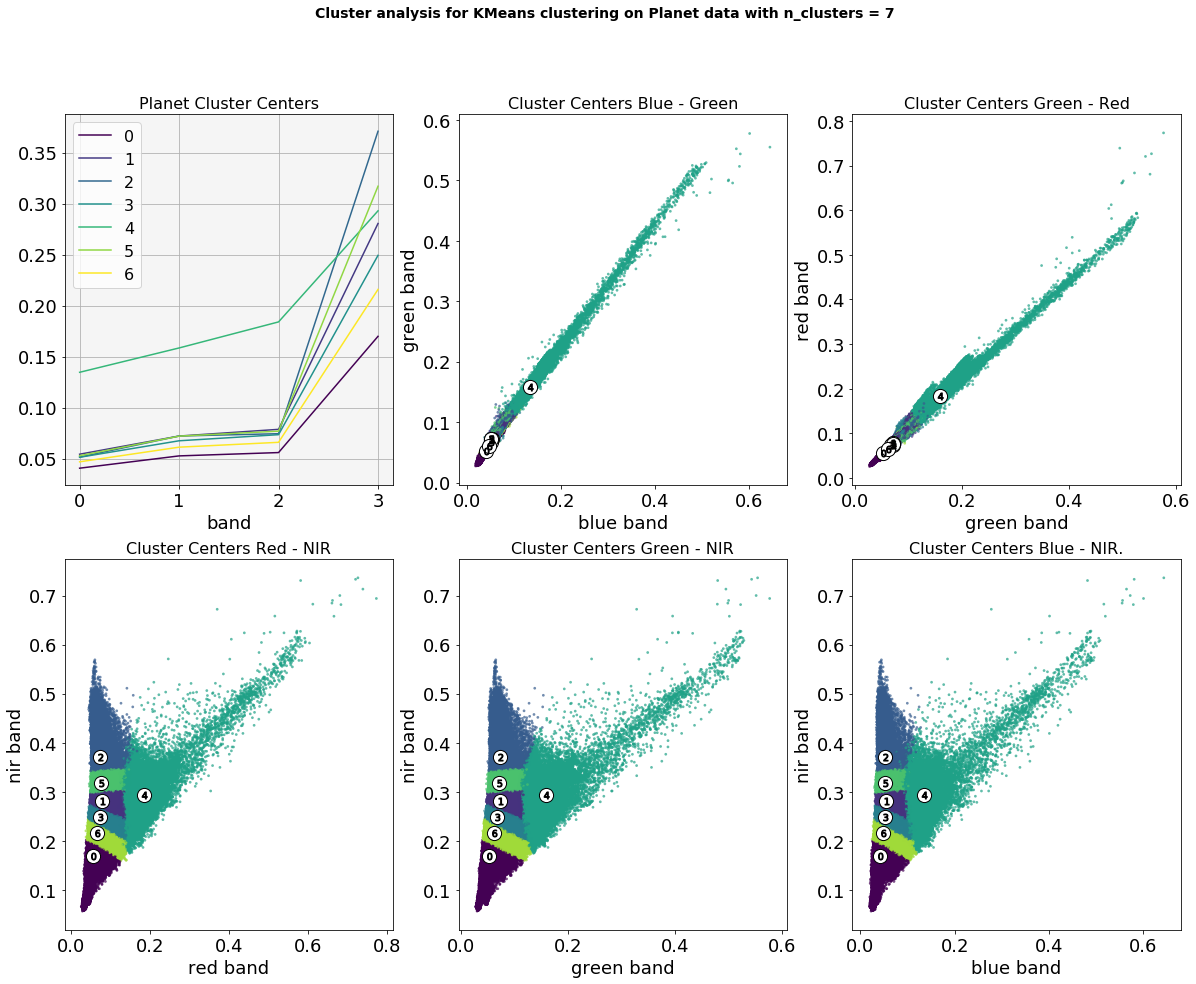

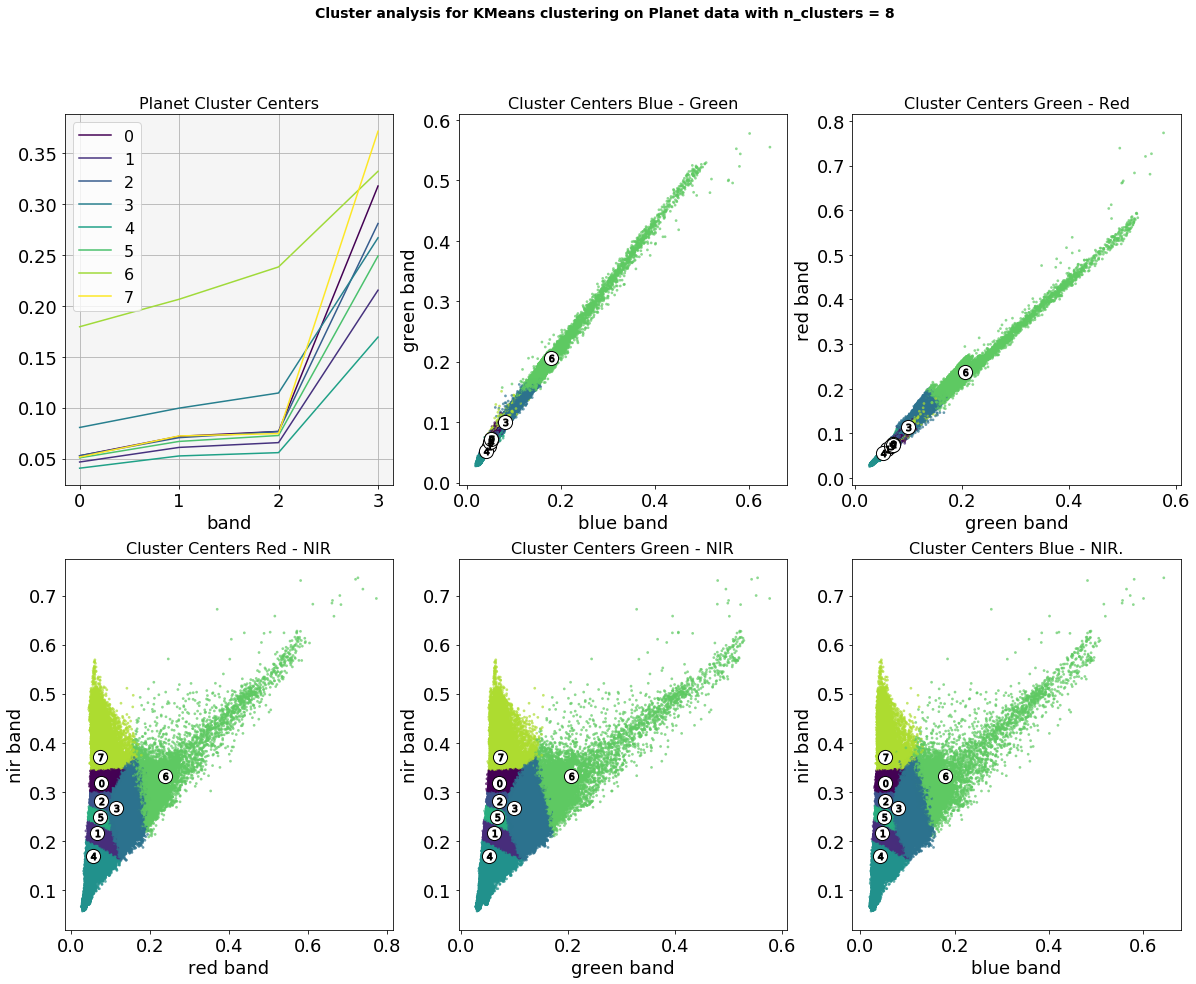

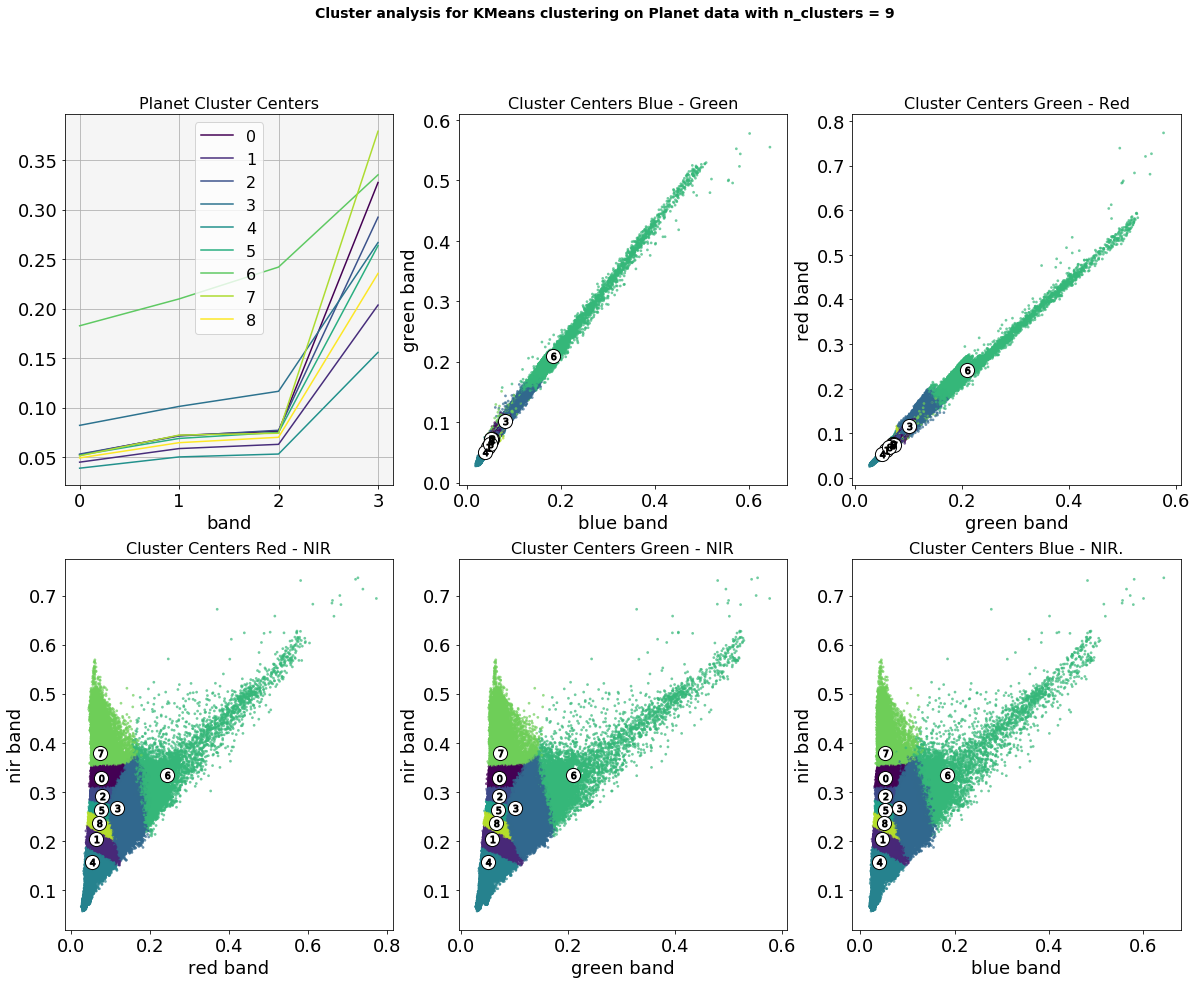

In [89]:
pl_inertia = []
pl_kmeans = []

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Xt)
    
    # store info
    pl_kmeans.append(clusterer)
    pl_inertia.append(clusterer.inertia_ / Xt.shape[0])

    y_lower = 10
    
    # plot the clusters
    colors=iter(plt.cm.viridis(np.linspace(0,1,n_clusters)))

    # set up the figure
    fig, axes = plt.subplots(2,3)
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[0,2]
    ax4 = axes[1,0]
    ax5 = axes[1,1]
    ax6 = axes[1,2]
    
    fig.set_size_inches(20, 15)
    
    centers = clusterer.cluster_centers_
    labels= [str(i) for i in range(centers.shape[0])]
    for i,c in enumerate(colors):
        ax1.plot(centers[i,:], color=c, label=labels[i])

    ax1.legend()
    ax1.set_title('Planet Cluster Centers')
    ax1.set_xlabel('band')
    ax1.set_facecolor('whitesmoke')
    ax1.grid()

    
    # 2nd Plot showing the actual clusters formed for blue vs. green
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Cluster Centers Blue - Green")
    ax2.set_xlabel("blue band")
    ax2.set_ylabel("green band")
    
    
    # 3rd Plot showing the actual clusters formed for green vs. red
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax3.scatter(X[:, 1], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax3.scatter(centers[:, 1], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax3.scatter(c[1], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax3.set_title("Cluster Centers Green - Red")
    ax3.set_xlabel("green band")
    ax3.set_ylabel("red band")
    
    # 4th Plot showing the actual clusters formed for red vs. nir
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax4.scatter(X[:, 2], X[:, -1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax4.scatter(centers[:, 2], centers[:, -1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax4.scatter(c[2], c[-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax4.set_title("Cluster Centers Red - NIR")
    ax4.set_xlabel("red band")
    ax4.set_ylabel("nir band")
    
    # 5th Plot showing the actual clusters formed for green vs. nir
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax5.scatter(X[:, 1], X[:, -1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax5.scatter(centers[:, 1], centers[:, -1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax5.scatter(c[1], c[-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax5.set_title("Cluster Centers Green - NIR")
    ax5.set_xlabel("green band")
    ax5.set_ylabel("nir band")
    
    # 5th Plot showing the actual clusters formed for blue vs. nir
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax6.scatter(X[:, 0], X[:, -1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax6.scatter(centers[:, 0], centers[:, -1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax6.scatter(c[0], c[-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax6.set_title("Cluster Centers Blue - NIR.")
    ax6.set_xlabel("blue band")
    ax6.set_ylabel("nir band")
    
    

    plt.suptitle(("Cluster analysis for KMeans clustering on Planet data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    figname = 'KMeans_Planet_clusters_{}.png'.format(n_clusters)
    fig_path = r'C:\Projects\RD\planet\SPIE_research\figs\kmeans_inertia'
    fig_file = os.path.join(fig_path, figname)
    fig.savefig(fig_file)
    plt.show()
    


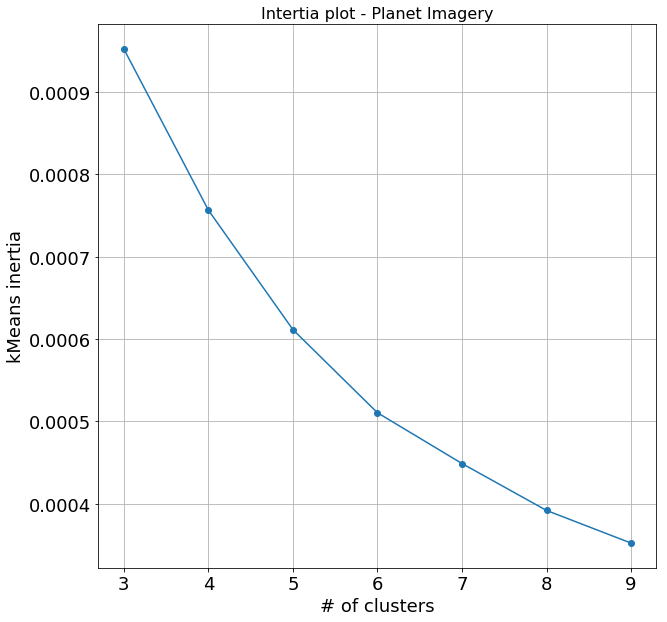

In [90]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(range_n_clusters, pl_inertia, 'o-')
ax.set_xlabel('# of clusters')
ax.set_ylabel('kMeans inertia')
ax.set_title('Intertia plot - Planet Imagery')
ax.set_xticks(range_n_clusters, minor=True)
ax.grid()

figname = 'KMeans_Planet_clusters_inertia.png'.format(n_clusters)
fig_path = r'C:\Projects\RD\planet\SPIE_research\figs\kmeans_inertia'
fig_file = os.path.join(fig_path, figname)
fig.savefig(fig_file)
plt.show()


## run the classification with K=7

In [77]:
clf = pl_kmeans[4]
clf

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

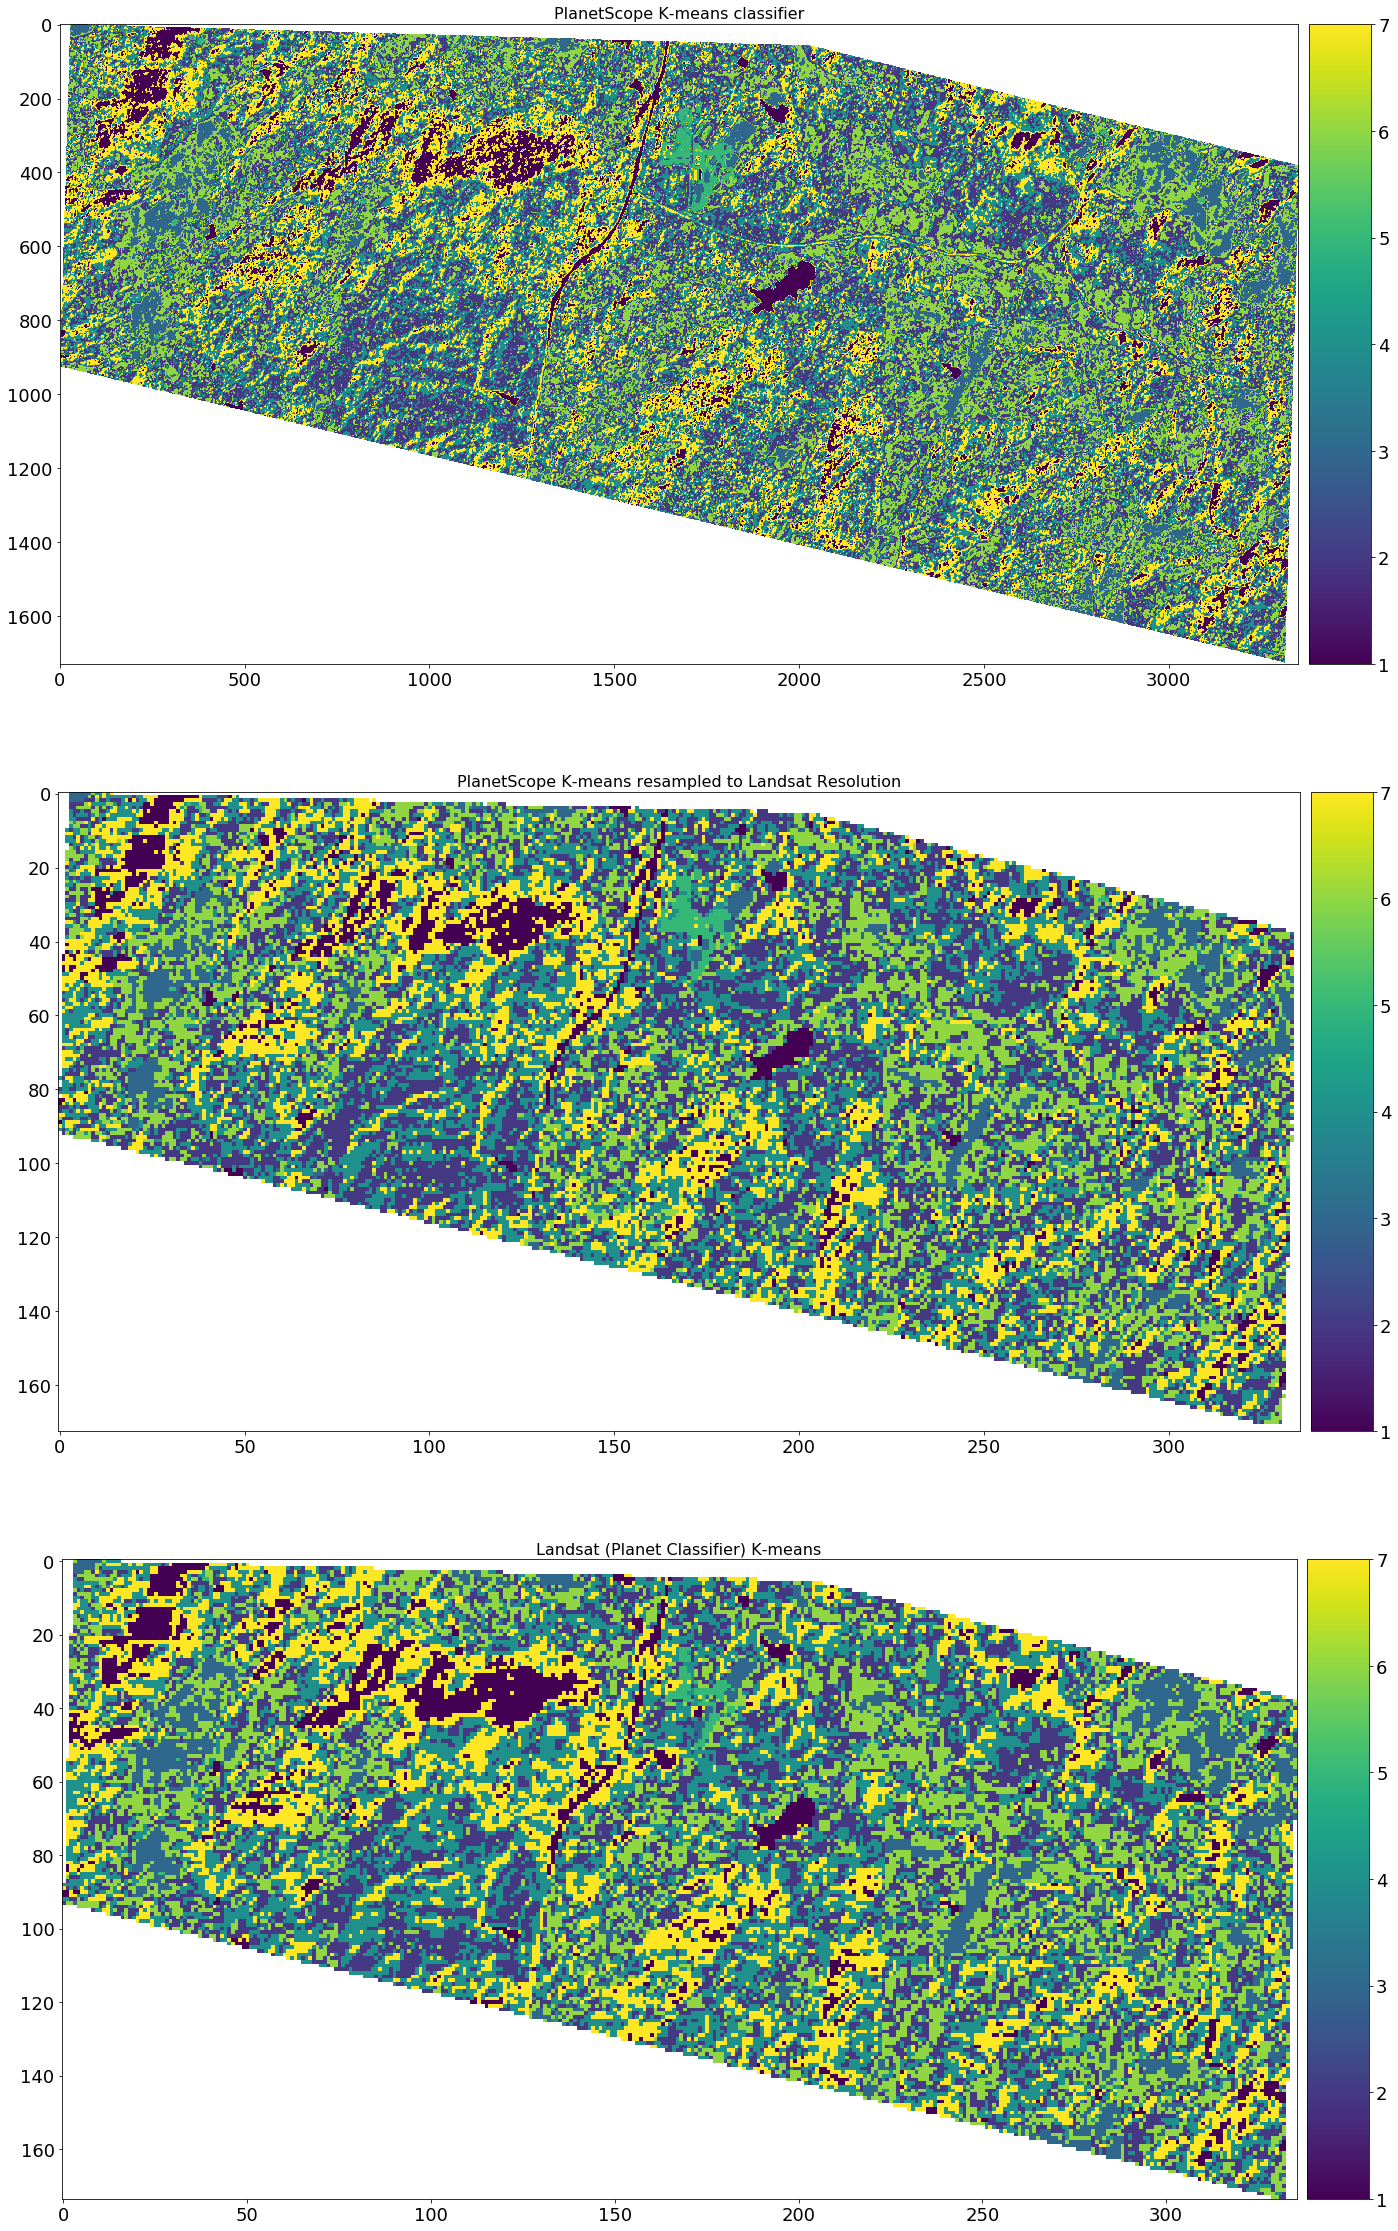

In [85]:
# make the X array
X_pl = pl_arr.reshape(-1,4)
mask = np.ma.getmask(X_pl)
mask_inds = np.where(~mask.all(axis=1))[0]
X_pl_c = X_pl[mask_inds,:]

# predict the array
predictedClass = clf.predict(X_pl_c)

# use the fit model
predictedClass = predictedClass + 1
predictedClass = np.expand_dims(predictedClass, axis=-1)
    
# reshape to array
pred_data_pl_pl = np.zeros((X_pl.shape[0], 1))
pred_data_pl_pl[~mask_inds] = predictedClass
pred_data_pl_pl = pred_data_pl_pl.reshape(pl_arr.shape[:2])
pred_data_pl_pl = np.ma.masked_equal(pred_data_pl_pl, 0)
pred_data_pl_pl = np.flipud(np.fliplr(pred_data_pl_pl))


# do the same for landsat 8
# make the X array
X_l8 = l8_arr.reshape(-1,4)
mask = np.ma.getmask(X_l8)
mask_inds = np.where(~mask.all(axis=1))[0]
X_l8_c = X_l8[mask_inds,:]

# predict the array
predictedClass = clf.predict(X_l8_c)

# use the fit model
predictedClass = predictedClass + 1
predictedClass = np.expand_dims(predictedClass, axis=-1)
    
# reshape to array
pred_data_pl_l8 = np.zeros((X_l8.shape[0], 1))
pred_data_pl_l8[~mask_inds] = predictedClass
pred_data_pl_l8 = pred_data_pl_l8.reshape(l8_arr.shape[:2])
pred_data_pl_l8 = np.ma.masked_equal(pred_data_pl_l8, 0)
pred_data_pl_l8 = np.flipud(np.fliplr(pred_data_pl_l8))

    
# do a majority resampling of the planet data

pl_resamp_l8 = majority_agg(pred_data_pl_pl.astype('int64'), 10)
pl_resamp_l8 = np.ma.masked_equal(pl_resamp_l8, 0)


fig, ax = plt.subplots(3,1, figsize = (40,40))
c = ax[0].imshow(pred_data_pl_pl)
ax[0].set_title('PlanetScope K-means classifier')
colorbar(c)
c = ax[1].imshow(pl_resamp_l8, vmin=1)
ax[1].set_title('PlanetScope K-means resampled to Landsat Resolution')
colorbar(c)
c = ax[2].imshow(pred_data_pl_l8)
ax[2].set_title('Landsat (Planet Classifier) K-means')
colorbar(c)
plt.show()

In [77]:
clf = l8_kmeans[4]
clf

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

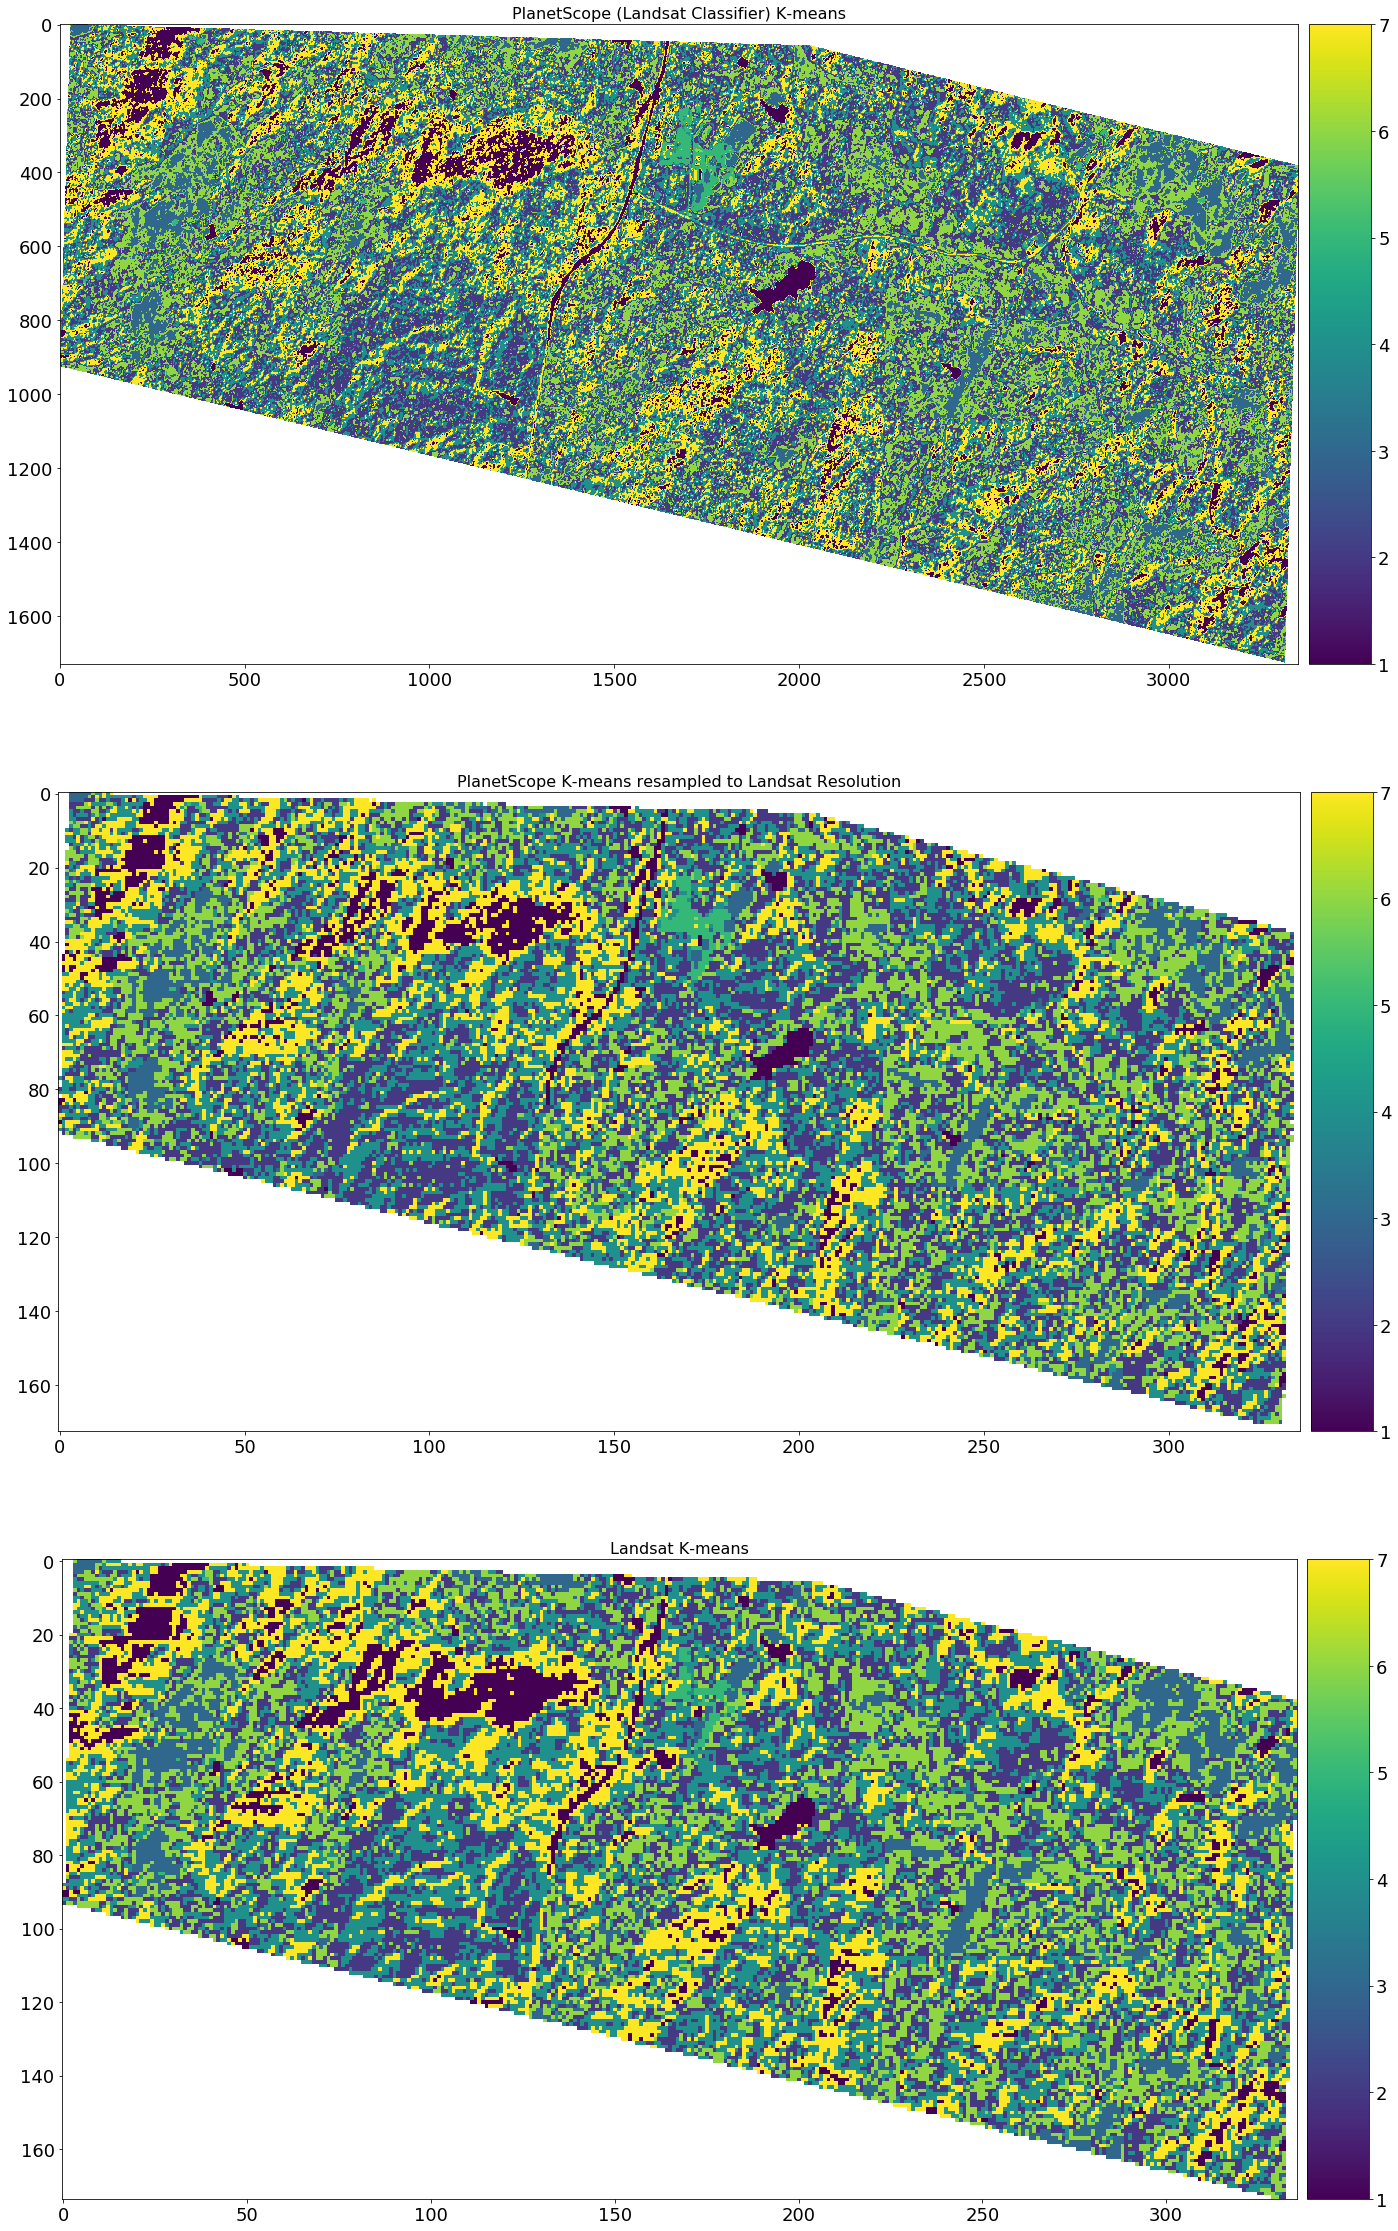

In [86]:
# make the X array
X_pl = pl_arr.reshape(-1,4)
mask = np.ma.getmask(X_pl)
mask_inds = np.where(~mask.all(axis=1))[0]
X_pl_c = X_pl[mask_inds,:]

# predict the array
predictedClass = clf.predict(X_pl_c)

# use the fit model
predictedClass = predictedClass + 1
predictedClass = np.expand_dims(predictedClass, axis=-1)
    
# reshape to array
pred_data_pl_pl = np.zeros((X_pl.shape[0], 1))
pred_data_pl_pl[~mask_inds] = predictedClass
pred_data_pl_pl = pred_data_pl_pl.reshape(pl_arr.shape[:2])
pred_data_pl_pl = np.ma.masked_equal(pred_data_pl_pl, 0)
pred_data_pl_pl = np.flipud(np.fliplr(pred_data_pl_pl))


# do the same for landsat 8
# make the X array
X_l8 = l8_arr.reshape(-1,4)
mask = np.ma.getmask(X_l8)
mask_inds = np.where(~mask.all(axis=1))[0]
X_l8_c = X_l8[mask_inds,:]

# predict the array
predictedClass = clf.predict(X_l8_c)

# use the fit model
predictedClass = predictedClass + 1
predictedClass = np.expand_dims(predictedClass, axis=-1)
    
# reshape to array
pred_data_pl_l8 = np.zeros((X_l8.shape[0], 1))
pred_data_pl_l8[~mask_inds] = predictedClass
pred_data_pl_l8 = pred_data_pl_l8.reshape(l8_arr.shape[:2])
pred_data_pl_l8 = np.ma.masked_equal(pred_data_pl_l8, 0)
pred_data_pl_l8 = np.flipud(np.fliplr(pred_data_pl_l8))

    
# do a majority resampling of the planet data

pl_resamp_l8 = majority_agg(pred_data_pl_pl.astype('int64'), 10)
pl_resamp_l8 = np.ma.masked_equal(pl_resamp_l8, 0)


fig, ax = plt.subplots(3,1, figsize = (40,40))
c = ax[0].imshow(pred_data_pl_pl)
ax[0].set_title('PlanetScope (Landsat Classifier) K-means')
colorbar(c)
c = ax[1].imshow(pl_resamp_l8, vmin=1)
ax[1].set_title('PlanetScope K-means resampled to Landsat Resolution')
colorbar(c)
c = ax[2].imshow(pred_data_pl_l8)
ax[2].set_title('Landsat K-means')
colorbar(c)
plt.show()

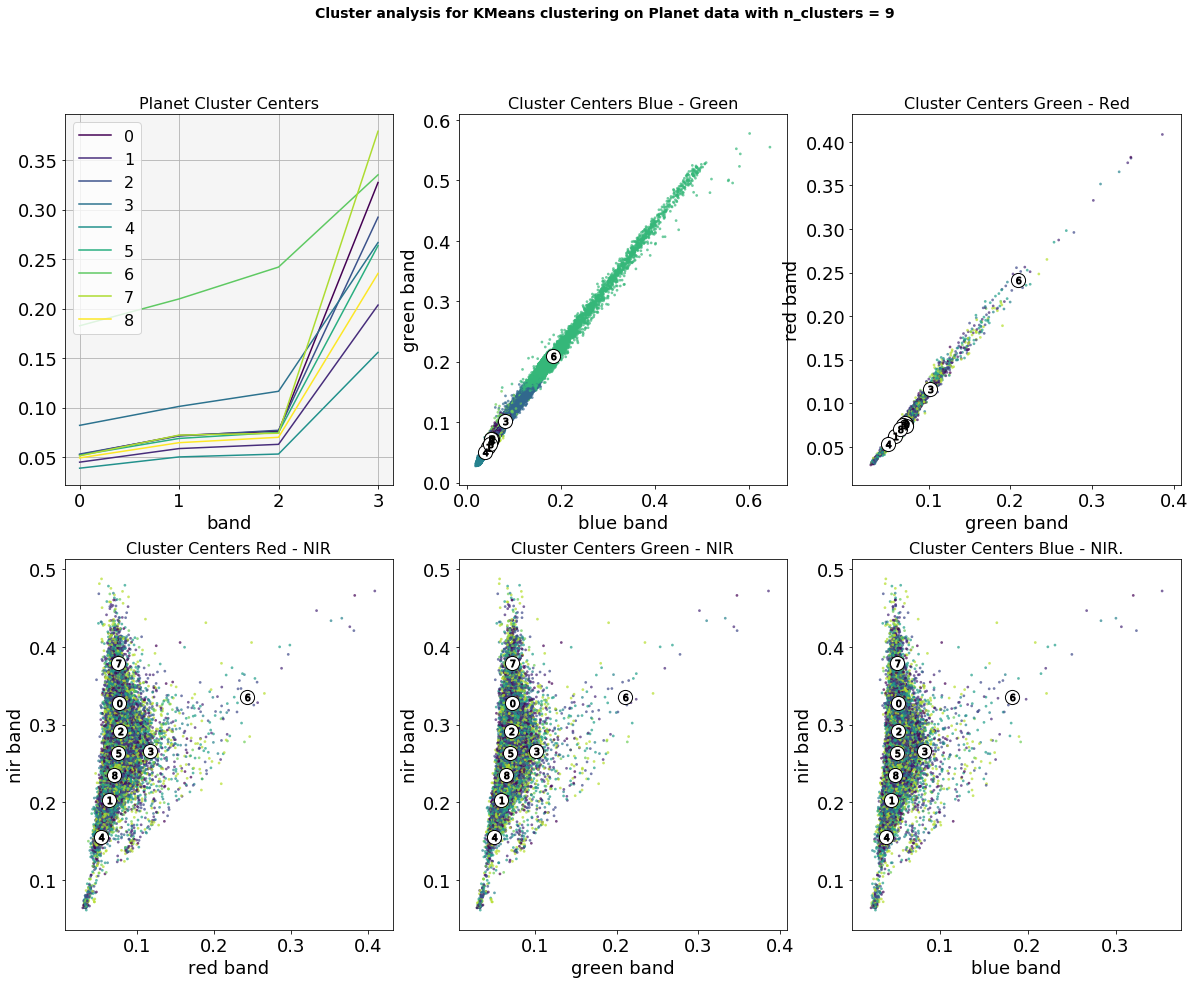

In [94]:
for n_clusters in [range_n_clusters[-1]]:
    
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     clusterer = pl_kmeans[-1]
#     cluster_labels = clusterer.predict(Xt)
    
    # store info
#     pl_kmeans.append(clusterer)
#     pl_inertia.append(clusterer.inertia_ / Xt.shape[0])

    y_lower = 10
    
    # plot the clusters
    colors=iter(plt.cm.viridis(np.linspace(0,1,n_clusters)))

    # set up the figure
    fig, axes = plt.subplots(2,3)
    ax1 = axes[0,0]
    ax2 = axes[0,1]
    ax3 = axes[0,2]
    ax4 = axes[1,0]
    ax5 = axes[1,1]
    ax6 = axes[1,2]
    
    fig.set_size_inches(20, 15)
    
    centers = clusterer.cluster_centers_
    labels= [str(i) for i in range(centers.shape[0])]
    for i,c in enumerate(colors):
        ax1.plot(centers[i,:], color=c, label=labels[i])

    ax1.legend(loc='upper left')
    ax1.set_title('Planet Cluster Centers')
    ax1.set_xlabel('band')
    ax1.set_facecolor('whitesmoke')
    ax1.grid()

    
    # 2nd Plot showing the actual clusters formed for blue vs. green
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Cluster Centers Blue - Green")
    ax2.set_xlabel("blue band")
    ax2.set_ylabel("green band")
    
    
    # 3rd Plot showing the actual clusters formed for green vs. red
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax3.scatter(X[:, 1], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax3.scatter(centers[:, 1], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax3.scatter(c[1], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax3.set_title("Cluster Centers Green - Red")
    ax3.set_xlabel("green band")
    ax3.set_ylabel("red band")
    
    # 4th Plot showing the actual clusters formed for red vs. nir
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax4.scatter(X[:, 2], X[:, -1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax4.scatter(centers[:, 2], centers[:, -1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax4.scatter(c[2], c[-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax4.set_title("Cluster Centers Red - NIR")
    ax4.set_xlabel("red band")
    ax4.set_ylabel("nir band")
    
    # 5th Plot showing the actual clusters formed for green vs. nir
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax5.scatter(X[:, 1], X[:, -1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax5.scatter(centers[:, 1], centers[:, -1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax5.scatter(c[1], c[-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax5.set_title("Cluster Centers Green - NIR")
    ax5.set_xlabel("green band")
    ax5.set_ylabel("nir band")
    
    # 5th Plot showing the actual clusters formed for blue vs. nir
    colors = plt.cm.viridis(cluster_labels.astype(float) / n_clusters)
    #colors = plt.cm.viridis(np.linspace(0,1,n_clusters))
    ax6.scatter(X[::100, 0], X[::100, -1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax6.scatter(centers[:, 0], centers[:, -1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax6.scatter(c[0], c[-1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax6.set_title("Cluster Centers Blue - NIR.")
    ax6.set_xlabel("blue band")
    ax6.set_ylabel("nir band")
    
    

    plt.suptitle(("Cluster analysis for KMeans clustering on Planet data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    figname = 'KMeans_Planet_clusters_{}.png'.format(n_clusters)
    fig_path = r'C:\Projects\RD\planet\SPIE_research\figs\kmeans_inertia'
    fig_file = os.path.join(fig_path, figname)
    #fig.savefig(fig_file)
    plt.show()

## pickle the list of classifiers

In [95]:
import pickle
l8_kmeans_pickle_file = 'l8_kmeans_classifier_list_3_9_classes_SJER_03122017.pickle'
pl_kmeans_pickle_file = 'pl_kmeans_classifier_list_3_9_classes_SJER_03122017.pickle'

with open(l8_kmeans_pickle_file, 'wb') as fi:
    pickle.dump(l8_kmeans, fi)
    
with open(pl_kmeans_pickle_file, 'wb') as fi:
    pickle.dump(pl_kmeans, fi)
    
!ls

Bayes_Gaussian_clustering.ipynb
Gaussian_clustering.ipynb
K_means_SIlhouette_plots.ipynb
K_means_classification.ipynb
K_means_intertia_landsat_planet_SJER.ipynb
l8_kmeans_classifier_list_3_9_classes_SJER_03122017.pickle
pl_kmeans_classifier_list_3_9_classes_SJER_03122017.pickle
